In [1]:
import sys
from pathlib import Path


root_dir = Path().absolute()
# Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
if root_dir.parts[-1:] == ('notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
root_dir = str(root_dir) 
print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/emaminotti/ID2223-ScalableMLDL_Project
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
import shutil
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import util
import json
import joblib

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> Connect to Hopsworks Feature Store </span>

In [3]:
import hopsworks

# Login e connessione ai servizi Hopsworks
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

# Configurazione per Stoccolma
# Inseriamo le coordinate usate per il backfill
city = "Stockholm"
country = "Sweden"
latitude = 59.3293
longitude = 18.0686


print(f"✅ Configurazione caricata per: {city} (Lat: {latitude}, Lon: {longitude})")

2025-12-15 17:05:57,269 INFO: Initializing external client
2025-12-15 17:05:57,270 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-12-15 17:05:59,504 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279152
✅ Configurazione caricata per: Stockholm (Lat: 59.3293, Lon: 18.0686)


In [4]:
try:
    pollen_fg = fs.get_feature_group(name="pollen_measurements", version=1)
    weather_fg = fs.get_feature_group(name="weather_measurements", version=1)
    
    print("✅ Feature Groups recuperati con successo:")
    print(f"   - {pollen_fg.name} (v{pollen_fg.version})")
    print(f"   - {weather_fg.name} (v{weather_fg.version})")

except Exception as e:
    print(f"❌ Errore nel recupero dei Feature Group: {e}")
    print("Assicurati di aver eseguito il notebook di backfill.")

✅ Feature Groups recuperati con successo:
   - pollen_measurements (v1)
   - weather_measurements (v1)


## <span style="color:#ff5f27;"> Feature View Creation and Retrieving </span>

In [5]:
# 1. Definizione della Query di Join
# Selezioniamo tutte le feature dai pollini e le uniamo al meteo.
# Hopsworks userà automaticamente la Primary Key comune ('city', 'unix_time') per unire i dati.
query = pollen_fg.select_all().join(weather_fg.select_all())

# 2. Definizione dei Target
# Queste sono le variabili che il modello dovrà imparare a predire
targets = ["alder_pollen", "birch_pollen", "grass_pollen", "mugwort_pollen"]

# 3. Creazione (o recupero) della Feature View
try:
    feature_view = fs.get_or_create_feature_view(
        name="pollen_stockholm_fv",
        version=1,
        description="Feature view for forecasting pollen levels in Stockholm joining air quality and weather data.",
        labels=targets,          # Specifichiamo le colonne target
        query=query              # La logica di join
    )
    
    print("✅ Feature View 'pollen_stockholm_fv' creata o recuperata con successo.")
    print(f"   Targets: {feature_view.labels}")
    print(f"   Query: {feature_view.query.to_string()}")

except Exception as e:
    print(f"❌ Errore nella creazione della Feature View: {e}")

2025-12-15 17:10:11,110 WARNING: Ambiguous features detected during query construction.The feature `time` is present in feature groups ['pollen_measurements version 1', 'weather_measurements version 1']. The feature `unix_time` is present in feature groups ['pollen_measurements version 1', 'weather_measurements version 1']. The feature `city` is present in feature groups ['pollen_measurements version 1', 'weather_measurements version 1']. Automatically prefixing features selected using these feature groups with the feature group name.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279152/fs/1258616/fv/pollen_stockholm_fv/version/1
✅ Feature View 'pollen_stockholm_fv' creata o recuperata con successo.
   Targets: ['alder_pollen', 'birch_pollen', 'grass_pollen', 'mugwort_pollen']
   Query: WITH right_fg0 AS (SELECT *
FROM (SELECT `fg1`.`time` `time`, `fg1`.`alder_pollen` `alder_pollen`, `fg1`.`birch_pollen` `birch_pollen`, `fg1`.`grass_pollen` `grass_

## <span style="color:#ff5f27;">Split the training data into train/test data sets </span>

In [6]:
# 1. Creazione del Training Dataset (Split temporale)
# Hopsworks salverà questa versione del dataset per riproducibilità.
# Usiamo test_size=0.2 per usare l'ultimo 20% dei dati come test.
version, job = feature_view.create_train_test_split(
    test_size=0.2,
    description='Time-series split (80% Train / 20% Test)',
    data_format='csv',
    write_options={'wait_for_job': True} # Attende che Hopsworks finisca di creare i file
)

print(f"✅ Training Dataset versione {version} creato con successo.")

# 2. Recupero dei DataFrame (X e y)
X_train, X_test, y_train, y_test = feature_view.get_train_test_split(version)

# 3. Ordinamento temporale (Cruciale per Time Series)
# Assicuriamoci che i dati siano ordinati per data per evitare errori nel plotting o training
X_train = X_train.sort_values("unix_time")
X_test = X_test.sort_values("unix_time")

# Allineiamo le y (target) agli indici ordinati di X
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

# 4. Verifica delle dimensioni
print(f"Train Set: {X_train.shape[0]} righe")
print(f"Test Set:  {X_test.shape[0]} righe")

# Mostra il periodo temporale coperto
train_start = pd.to_datetime(X_train['unix_time'].min(), unit='ms').date()
train_end = pd.to_datetime(X_train['unix_time'].max(), unit='ms').date()
test_start = pd.to_datetime(X_test['unix_time'].min(), unit='ms').date()
test_end = pd.to_datetime(X_test['unix_time'].max(), unit='ms').date()

print(f"\n📅 Periodo Training: {train_start} -> {train_end}")
print(f"📅 Periodo Testing:  {test_start} -> {test_end}")

display(X_train.head(3))

Training dataset job started successfully, you can follow the progress at 
http://c.app.hopsworks.ai/p/1279152/jobs/named/pollen_stockholm_fv_1_create_fv_td_15122025161135/executions
2025-12-15 17:11:45,847 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-12-15 17:11:49,019 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-15 17:21:36,460 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-15 17:21:36,624 INFO: Waiting for log aggregation to finish.
2025-12-15 17:21:45,225 INFO: Execution finished successfully.
✅ Training Dataset versione 1 creato con successo.
2025-12-15 17:24:45,865 INFO: Provenance cached data - overwriting last accessed/created training dataset from 1 to 1.
Train Set: 91145 righe
Test Set:  22492 righe

📅 Periodo Training: 2013-01-01 -> 2025-12-18
📅 Periodo Testing:  2013-01-01 -> 2025-12-18


,time,unix_time,city,country,alder_pollen_lag_1,alder_pollen_lag_2,alder_pollen_lag_3,birch_pollen_lag_1,birch_pollen_lag_2,birch_pollen_lag_3,...,weather_measurements_precipitation_sum,weather_measurements_rain_sum,weather_measurements_showers_sum,weather_measurements_snowfall_sum,weather_measurements_precipitation_hours,weather_measurements_wind_speed_10m_max,weather_measurements_wind_gusts_10m_max,weather_measurements_wind_direction_10m_dominant,weather_measurements_shortwave_radiation_sum,weather_measurements_et0_fao_evapotranspiration
5418,2013-01-01T03:00:00.000Z,1357009200000,Stockholm,Sweden,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77945,2013-01-01T04:00:00.000Z,1357012800000,Stockholm,Sweden,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81150,2013-01-01T05:00:00.000Z,1357016400000,Stockholm,Sweden,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <span style="color:#ff5f27;">Modeling</span>

In [9]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Configurazione del Modello
# RIMOSSO: early_stopping_rounds (incompatibile con MultiOutputRegressor senza logica complessa)
xgb_estimator = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

# 2. Avvolgiamo XGBoost nel MultiOutputRegressor
model = MultiOutputRegressor(xgb_estimator)

print("🚀 Avvio del training del modello Multi-Output XGBoost...")

# 3. Preparazione Feature
# Rimuoviamo 'country' (stringa) e le altre colonne non utili
features_to_drop = ['city', 'country', 'date', 'time', 'unix_time'] 
# Nota: Ho rimosso anche 'unix_time' per sicurezza, ma puoi tenerlo se vuoi il trend.
# Di solito per XGBoost è meglio rimuovere le date grezze se non trasformate.

train_cols = [c for c in X_train.columns if c not in features_to_drop]

print(f"Features utilizzate ({len(train_cols)}): {train_cols}")

# 4. Addestramento
model.fit(X_train[train_cols], y_train)

print("✅ Training completato.")

# 5. Valutazione sul Test Set
y_pred = model.predict(X_test[train_cols])

# Calcolo metriche per ogni target
print("\n📊 Valutazione del Modello (R^2 Score e RMSE):")
r2_scores = []

for i, target_col in enumerate(y_test.columns):
    # R2 Score
    r2 = r2_score(y_test[target_col], y_pred[:, i])
    r2_scores.append(r2)
    
    # RMSE
    mse = mean_squared_error(y_test[target_col], y_pred[:, i])
    rmse = np.sqrt(mse)
    
    print(f"   🔹 {target_col}: R2 = {r2:.3f} | RMSE = {rmse:.2f}")

print(f"\n   ⭐ Media R2 Score: {np.mean(r2_scores):.3f}")

🚀 Avvio del training del modello Multi-Output XGBoost...
Features utilizzate (26): ['alder_pollen_lag_1', 'alder_pollen_lag_2', 'alder_pollen_lag_3', 'birch_pollen_lag_1', 'birch_pollen_lag_2', 'birch_pollen_lag_3', 'grass_pollen_lag_1', 'grass_pollen_lag_2', 'grass_pollen_lag_3', 'mugwort_pollen_lag_1', 'mugwort_pollen_lag_2', 'mugwort_pollen_lag_3', 'weather_measurements_time', 'weather_measurements_temperature_2m_max', 'weather_measurements_temperature_2m_min', 'weather_measurements_temperature_2m_mean', 'weather_measurements_precipitation_sum', 'weather_measurements_rain_sum', 'weather_measurements_showers_sum', 'weather_measurements_snowfall_sum', 'weather_measurements_precipitation_hours', 'weather_measurements_wind_speed_10m_max', 'weather_measurements_wind_gusts_10m_max', 'weather_measurements_wind_direction_10m_dominant', 'weather_measurements_shortwave_radiation_sum', 'weather_measurements_et0_fao_evapotranspiration']
✅ Training completato.

📊 Valutazione del Modello (R^2 Sco

📊 REPORT DI VALUTAZIONE DETTAGLIATO
------------------------------------------------------------
🔹 ALDER_POLLEN
   MAE:  0.02 (Errore medio assoluto)
   RMSE: 0.48 (Penalizza i grandi errori sui picchi)
   R2:   0.585 (Bontà del fit)
------------------------------
🔹 BIRCH_POLLEN
   MAE:  1.32 (Errore medio assoluto)
   RMSE: 13.63 (Penalizza i grandi errori sui picchi)
   R2:   0.924 (Bontà del fit)
------------------------------
🔹 GRASS_POLLEN
   MAE:  0.09 (Errore medio assoluto)
   RMSE: 0.50 (Penalizza i grandi errori sui picchi)
   R2:   0.961 (Bontà del fit)
------------------------------
🔹 MUGWORT_POLLEN
   MAE:  0.05 (Errore medio assoluto)
   RMSE: 0.39 (Penalizza i grandi errori sui picchi)
   R2:   0.932 (Bontà del fit)
------------------------------


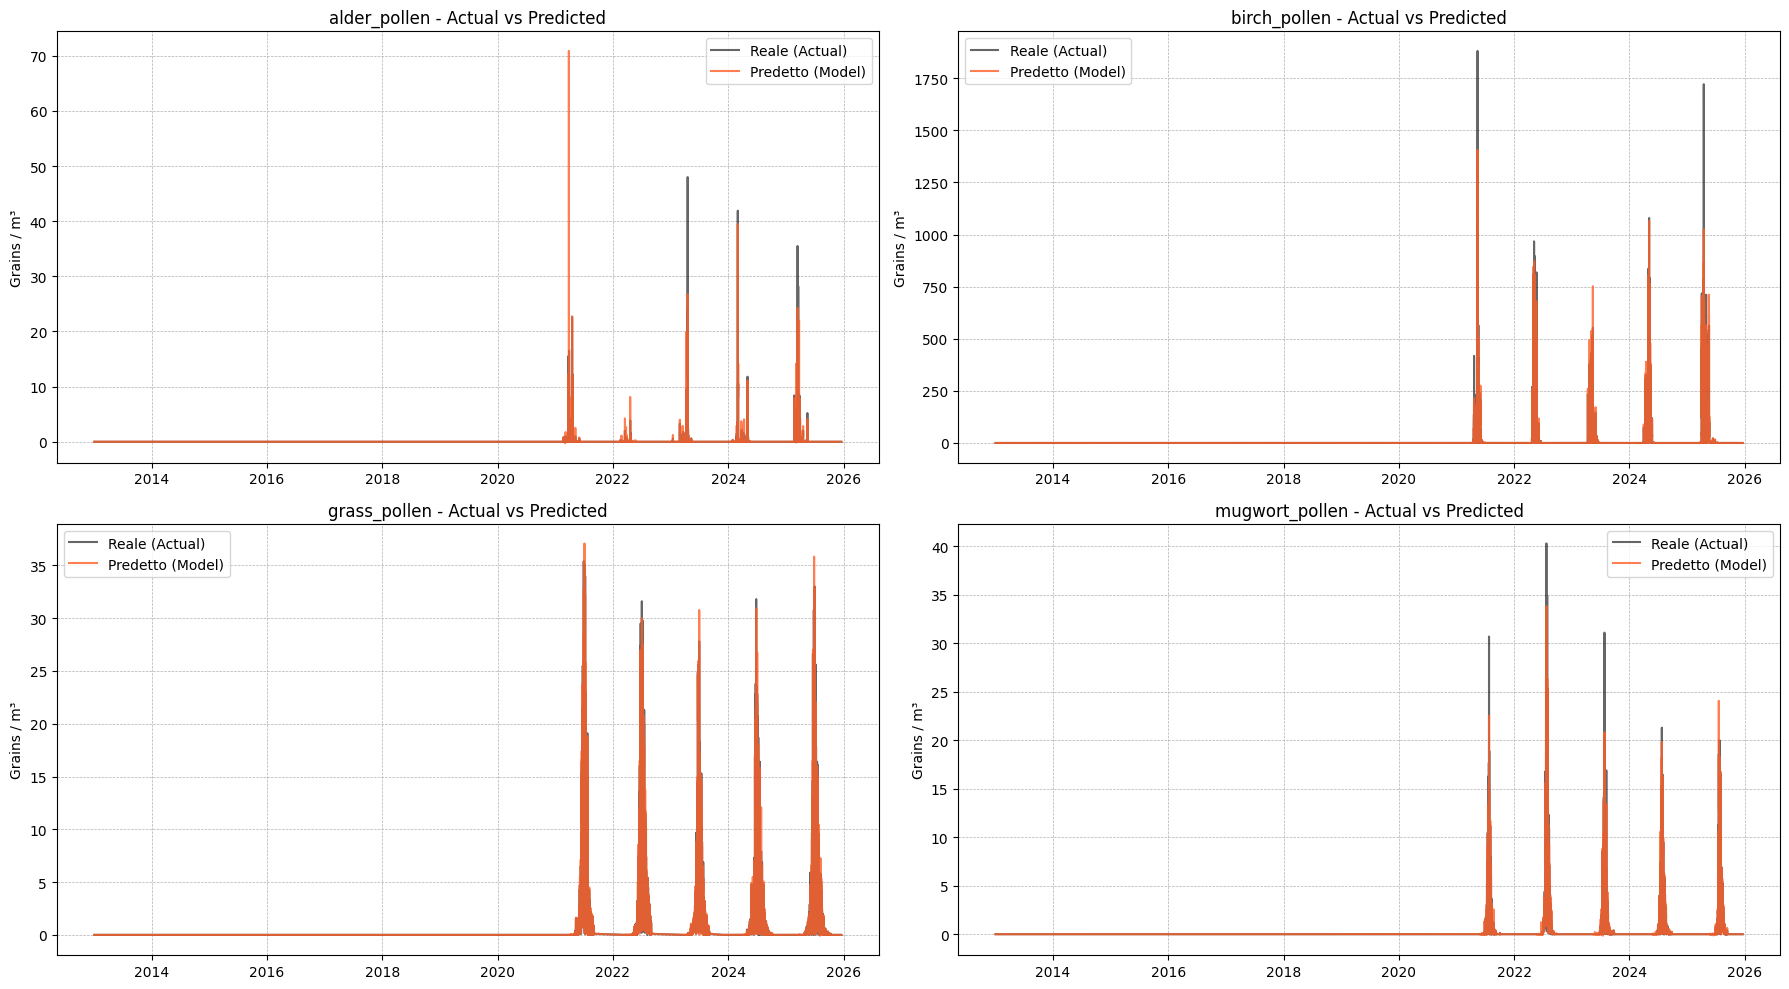


🔍 Analisi rapida dei residui (Differenza Predetto - Reale)
                    mean        std         min         max
alder_pollen   -0.003487   0.484585  -56.774321   21.257116
birch_pollen    0.097179  13.633971 -342.059399  892.872815
grass_pollen    0.000055   0.496791   -9.681305   10.291567
mugwort_pollen -0.002156   0.391496  -11.219048   13.645524


In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error

# 1. Preparazione dell'asse temporale per i grafici
# Recuperiamo le date dal test set per avere un asse X leggibile
if 'unix_time' in X_test.columns:
    dates = pd.to_datetime(X_test['unix_time'], unit='ms')
else:
    # Fallback se unix_time non è tra le feature (es. rimosso prima)
    # Recuperiamolo dalla Feature View se necessario, o usiamo un range numerico
    dates = range(len(y_test))

# 2. Setup del layout grafico (2 righe x 2 colonne)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axs = axs.flatten()

print("📊 REPORT DI VALUTAZIONE DETTAGLIATO")
print("-" * 60)

targets = y_test.columns

for i, col in enumerate(targets):
    # Dati Reali vs Predetti
    y_true_col = y_test[col]
    y_pred_col = y_pred[:, i]
    
    # --- Calcolo Metriche ---
    mae = mean_absolute_error(y_true_col, y_pred_col)
    mse = mean_squared_error(y_true_col, y_pred_col)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_col, y_pred_col)
    
    # Stampa metriche testuali
    print(f"🔹 {col.upper()}")
    print(f"   MAE:  {mae:.2f} (Errore medio assoluto)")
    print(f"   RMSE: {rmse:.2f} (Penalizza i grandi errori sui picchi)")
    print(f"   R2:   {r2:.3f} (Bontà del fit)")
    print("-" * 30)
    
    # --- Visualizzazione Grafica ---
    ax = axs[i]
    
    # Plot Reale vs Predetto
    # Usiamo 'alpha' per la trasparenza e vedere le sovrapposizioni
    ax.plot(dates, y_true_col, label='Reale (Actual)', color='black', alpha=0.6, linewidth=1.5)
    ax.plot(dates, y_pred_col, label='Predetto (Model)', color='#ff5f27', alpha=0.8, linewidth=1.5)
    
    ax.set_title(f"{col} - Actual vs Predicted")
    ax.set_ylabel("Grains / m³")
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# 3. Analisi dei Residui (Opzionale ma consigliata)
# Un buon modello dovrebbe avere residui (Errori) distribuiti attorno allo zero senza pattern
print("\n🔍 Analisi rapida dei residui (Differenza Predetto - Reale)")
residuals = y_test - y_pred
print(residuals.describe().T[['mean', 'std', 'min', 'max']])

🔍 Top 10 Feature più importanti (Media generale):


,MEAN_IMPORTANCE
grass_pollen_lag_1,0.241274
birch_pollen_lag_1,0.234291
mugwort_pollen_lag_1,0.233567
alder_pollen_lag_1,0.175019
alder_pollen_lag_2,0.060302
alder_pollen_lag_3,0.010714
birch_pollen_lag_2,0.010698
grass_pollen_lag_3,0.009063
birch_pollen_lag_3,0.007902
grass_pollen_lag_2,0.007129


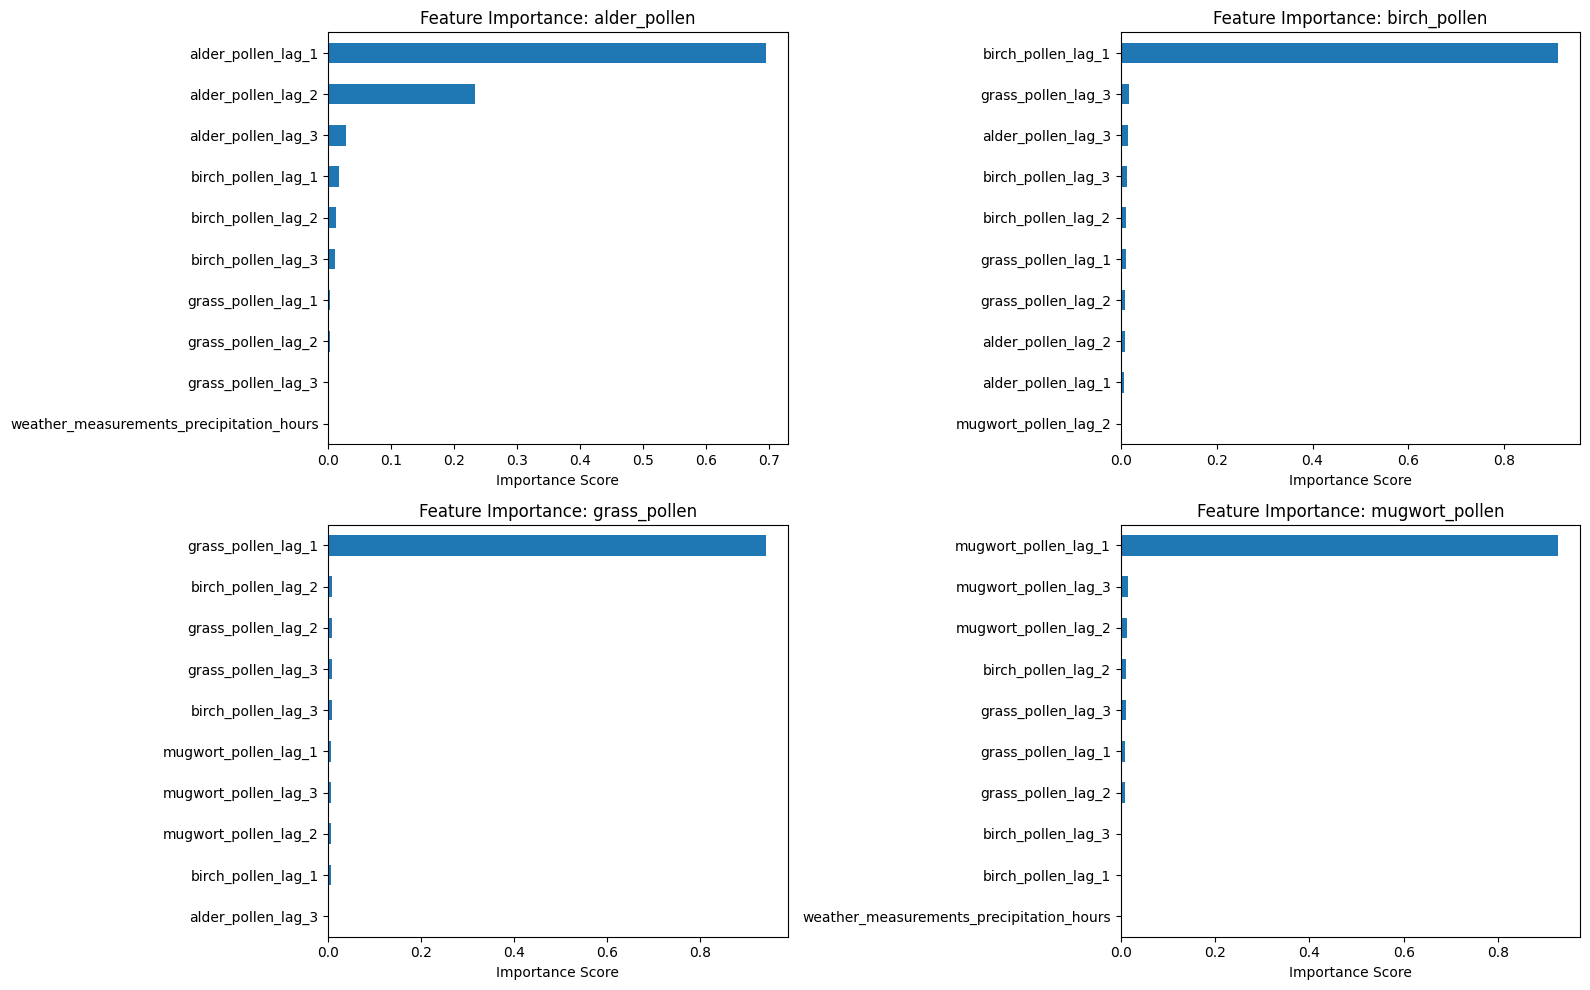

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Recuperiamo i nomi delle feature usate nel training
feature_names = train_cols

# Recuperiamo i nomi dei target (es. alder_pollen, birch_pollen...)
target_names = y_test.columns

# Creiamo un DataFrame per raccogliere le importanze
# model.estimators_ contiene la lista dei modelli XGBoost addestrati (uno per target)
importance_df = pd.DataFrame(index=feature_names)

for i, target in enumerate(target_names):
    # Estraiamo l'importanza delle feature per l'i-esimo modello
    importance = model.estimators_[i].feature_importances_
    importance_df[target] = importance

# Calcoliamo anche una media generale
importance_df['MEAN_IMPORTANCE'] = importance_df.mean(axis=1)

# Ordiniamo in base alla media
importance_df = importance_df.sort_values(by='MEAN_IMPORTANCE', ascending=False)

print("🔍 Top 10 Feature più importanti (Media generale):")
display(importance_df[['MEAN_IMPORTANCE']].head(10))

# --- Visualizzazione Grafica ---
# Plot delle top 10 feature per ogni polline
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten()

for i, target in enumerate(target_names):
    # Ordiniamo le feature per questo specifico target
    top_features = importance_df[target].sort_values(ascending=False).head(10)
    
    # Bar plot
    top_features.plot(kind='barh', ax=axes[i], color='#1f77b4')
    axes[i].set_title(f"Feature Importance: {target}")
    axes[i].set_xlabel("Importance Score")
    axes[i].invert_yaxis() # Per avere la feature più importante in alto

plt.tight_layout()
plt.show()

## <span style='color:#ff5f27'>Model Registry</span>

In [14]:
import joblib
import os
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# 1. Connessione al Model Registry
mr = project.get_model_registry()

# 2. Definizione dello Schema
input_schema = Schema(X_train[train_cols])
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# 3. Preparazione Input Example
input_example = X_train[train_cols].sample(1)

# 4. Raccolta Metriche
metrics = {
    "mean_r2": np.mean(r2_scores),
    "mean_rmse": np.mean([np.sqrt(mean_squared_error(y_test[col], y_pred[:, i])) for i, col in enumerate(y_test.columns)])
}

# 5. Salvataggio del modello in locale (Step Fondamentale)
# Creiamo una cartella temporanea per gli artefatti del modello
model_dir = "pollen_model_artifacts"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Serializziamo il modello su disco usando joblib
joblib.dump(model, model_dir + "/pollen_xgboost_model.pkl")
print(f"Modello salvato localmente in: {model_dir}/pollen_xgboost_model.pkl")

# 6. Creazione dell'Oggetto Modello su Hopsworks
pollen_model = mr.python.create_model(
    name="pollen_stockholm_xgboost", 
    version=1,
    metrics=metrics,
    model_schema=model_schema,
    input_example=input_example, 
    description="Multi-Output XGBoost Regressor for Stockholm Pollen Prediction."
)

# 7. Upload su Hopsworks
# Passiamo il PERCORSO DELLA CARTELLA, non l'oggetto modello
print("💾 Upload del modello sul Model Registry...")
pollen_model.save(model_dir)

print("✅ Modello caricato correttamente!")
print(f"   Link: https://c.app.hopsworks.ai/p/{project.id}/models/{pollen_model.name}/{pollen_model.version}")

Modello salvato localmente in: pollen_model_artifacts/pollen_xgboost_model.pkl
💾 Upload del modello sul Model Registry...


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/emaminotti/ID2223-ScalableMLDL_Project/notebooks/pollen_model_artifacts/pollen_xgboost_model.…

Uploading /Users/emaminotti/ID2223-ScalableMLDL_Project/notebooks/input_example.json: 0.000%|          | 0/130…

Uploading /Users/emaminotti/ID2223-ScalableMLDL_Project/notebooks/model_schema.json: 0.000%|          | 0/2807…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279152/models/pollen_stockholm_xgboost/1
✅ Modello caricato correttamente!
   Link: https://c.app.hopsworks.ai/p/1279152/models/pollen_stockholm_xgboost/1
